Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

### 1. Подготовка данных


In [5]:
from IPython.display import display
import pandas as pd
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import shuffle
from sklearn.metrics import mean_absolute_error

In [6]:
# Разработанные функции из файла funktions
from funktions import number_of_passes

# 1. Подготовка данных

In [7]:
df_car = pd.read_csv('/home/varcady/Документы/Project_YDX/2_Yandex/10_car_price/autos.csv')
display(number_of_passes(df_car))
#df_car.info()

,specifications,sum_NaN,passes_NaN
0,VehicleType,37490,10.6
1,NotRepaired,71154,20.1
2,Model,19705,5.6
3,Gearbox,19833,5.6
4,FuelType,32895,9.3


## Вывод
Наша задача оставить данные максимально близкие к реальности, допускаем восстановление пропусков посредством агрегации по другим признакам где это возможно с минимальными искажениями.
1. DateCrawled, NumberOfPictures, LastSeen, DateCreated  - не имеющая отношения к цене информация - удаляем;
2. Строки с NaN по признакам, которые имеют большое влияние на цену без возможноти восстановления - удаляем; 
3. Строки с выбросами удаляем
4. Строки с ценой менее 50 евро принимаем как неадекватные - оценивать меньше не имеет смысла.
5. Нулевой месяц принимаем - как случай с неизвестным месяцем регистрации.

In [8]:
df_car = df_car.drop({'DateCrawled', 'NumberOfPictures', 'LastSeen', 'DateCreated', 'PostalCode'}, axis=1)
df_car.dropna(subset=['Model', 'Gearbox', 'FuelType'], inplace=True)
# Заполнение ячеек дата сет по условию
df_car = df_car[(df_car['Power'] >= 30) & (df_car['Power'] <= 247)]
df_car = df_car[(df_car['RegistrationYear'] <= 2014) & (df_car['RegistrationYear'] >= 1990)]
df_car = df_car[df_car['Kilometer'] >= 5000]
df_car = df_car[(df_car['Price'] >= 100) & (df_car['Price'] <= 16000)].reset_index(drop=True)
df_car['Power'] = df_car['Power'].replace(0, np.nan)
df_car['Power'] = (df_car.groupby(['Model', 'RegistrationYear', 'FuelType', 'Gearbox'])['Power']
                  .apply(lambda x: x.fillna(x.median())))
df_car.shape
#pd.DataFrame(df_car['Power'].value_counts()).head(30)

(243315, 11)

In [9]:
df_car['NotRepaired'] = df_car['NotRepaired'].fillna('no')
df_car['VehicleType'] = df_car['NotRepaired'].fillna('other')
display(df_car.head())

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,9800,no,2004,auto,163,grand,125000,8,gasoline,jeep,no
1,1500,no,2001,manual,75,golf,150000,6,petrol,volkswagen,no
2,3600,no,2008,manual,69,fabia,90000,7,gasoline,skoda,no
3,650,yes,1995,manual,102,3er,150000,10,petrol,bmw,yes
4,2200,no,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no


In [10]:
# Построение гисторамм и ящиков с усами рядом друг с другом. 
def make_many_subplots(df, title):
    fig = make_subplots(rows = 4, cols = 2)# 4 графика в 2 ряда
    fig.add_trace(go.Histogram(x=df['Price'], name='Цена' ), row =1, col=1)
    fig.add_trace(go.Histogram(x=df['Power'], name='Мощность двигателя'), row =2, col=1)
    fig.add_trace(go.Histogram(x=df['Kilometer'], name='Пробег'), row=3, col=1)
    fig.add_trace(go.Histogram(x=df['RegistrationYear'], name='Год регистрации'), row=4, col=1)

    fig.add_trace(go.Box(y=df['Price'], name='Цена'), row=1, col=2)
    fig.add_trace(go.Box(y=df['Power'], name='Мощность двигателя'), row=2, col=2)
    fig.add_trace(go.Box(y=df['Kilometer'], name='Пробег'), row=3, col=2)
    fig.add_trace(go.Box(y=df['RegistrationYear'], name = 'Год регистрации'), row=4, col=2)
    
    fig.update_layout(height=800, width=1000, title_text=title)
    fig.show()

In [31]:
# make_many_subplots(df_car, 'Основные показатели')

In [12]:

columns_en = ['VehicleType', 'Gearbox', 'Model', 'FuelType','NotRepaired', 'Brand']
enc = OrdinalEncoder()
df_car[columns_en] = (enc.fit_transform(df_car[columns_en], df_car.columns)).astype(int)
df_car_grad = df_car.copy()
#df_car.describe()

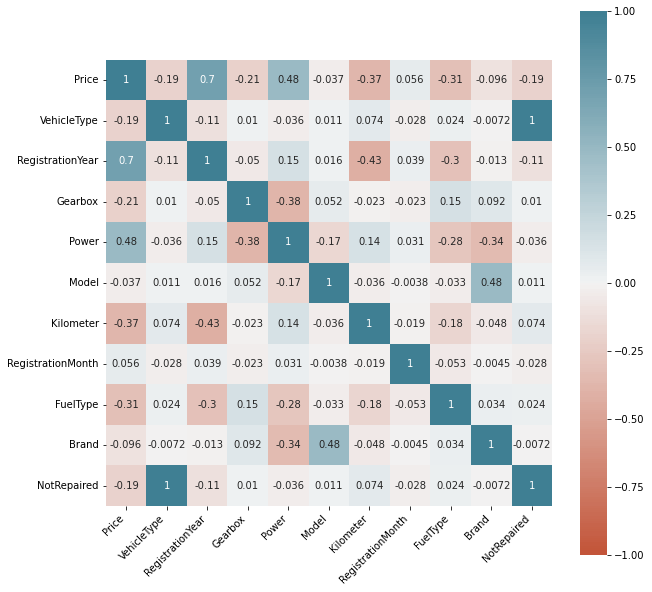

In [13]:
# Проверим данные на корреляции, если больше 80% один из признаков нужно удалить
corr = df_car.corr()
fig, ax = plt.subplots(figsize=(10,10)) 
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
);

In [14]:
# Разделим данные на признаки и целевой признак, заодно удалим коррелированный признак
features = df_car.drop(['Price', 'VehicleType'], axis = 1)
target = df_car['Price']

In [15]:
features.head()

,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,2004,0,163,117,125000,8,2,14,0
1,2001,1,75,116,150000,6,6,37,0
2,2008,1,69,101,90000,7,2,31,0
3,1995,1,102,11,150000,10,6,2,1
4,2004,1,109,8,150000,8,6,25,0


In [16]:
# Стратифицируем выборку и разделим на обучающую и тестовую
# Для стратификации выборки по целевому признаку найдем его 10 квантилей - это будут корзины
bins = np.quantile(target, np.arange(0,1,0.1)) 
# распределим целевой признак по этим корзинкам
target_binned = np.digitize(target, bins) 
# инициализиуем сплиттер, нам надо разделить на 2 выборки: train, valid
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=12345)
# получаем интексы для разделения выборок на основе binned таргета
train_index, test_index = sss.split(features, target_binned)
# используем индексы для получения выборок
features_train, features_test = features.iloc[train_index[0]], features.iloc[test_index[1]]
target_train, target_test = target.iloc[train_index[0]], target.iloc[test_index[1]]
print('Размеры выборок:')
print('Обучающая:', features_train.shape)
print('Тестовая:', features_test.shape)   
#инициализируем стандартизатор
scaler = StandardScaler()
# обучаем его на train
scaler.fit(features_train)
# трансформируем и train и test
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

Размеры выборок:
Обучающая: (194652, 9)
Тестовая: (48663, 9)


# 2. Обучение моделей

#### Подбор гиперпараметров модели решающего дерева 

In [17]:
# Запишем параметры модели
tree_params = {
    'max_depth': range(2,20),
    'min_samples_leaf': range(2,4),
    'min_samples_split': range(2,5)}

In [18]:
# start = time.time()
# # Найдем оптимальные гиперпараметры
# tree = DecisionTreeRegressor(random_state=12345)
# tree_grid = GridSearchCV(tree, tree_params, cv=3, n_jobs=-1, scoring='neg_mean_absolute_error', verbose=True)
# # Обучим модель
# tree_grid.fit(features_train, target_train)
# # печать оптимальных параметров
# print(tree_grid.best_params_, tree_grid.best_score_)
# end = time.time()
# Tree_time1 = round(end - start, 1)
# print(Tree_time1)

# {'max_depth': 17, 'min_samples_leaf': 3, 'min_samples_split': 2} -987.2782158345866

#### Подбор гиперпараметров модели Случайного леса

In [19]:
forest_params = {
    'min_samples_split': [2, 3],
    'min_samples_leaf': [2, 4],
    'n_estimators': range(200, 300, 50)}

In [20]:
# start = time.time()
# # Найдем оптимальные гиперпараметры
# forest = RandomForestRegressor(random_state=12345)
# forest_class_weight = GridSearchCV(forest, forest_params, cv=3, n_jobs=-1, scoring='neg_mean_absolute_error', verbose=True)
# # Обучим модель
# forest_class_weight.fit(features_train, target_train)
# print(forest_class_weight.best_params_, forest_class_weight.best_score_)
# end = time.time()
# Forest_time1 = round(end - start, 1)
# print(Forest_time1)

# {'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 250} -885.6401313792976

#### Подбор гиперпараметров модели LGBM

In [21]:
LGBM_params = {
    'max_depth': range(5,10),
    'num_leaves': range(6,10),
    'n_estimators': range(1000, 2000, 100)}

In [22]:
# start = time.time()
# # Найдем оптимальные гиперпараметры 
# model_LGBM = LGBMRegressor(random_state=287)

# LGBM_class_weight = GridSearchCV(model_LGBM, LGBM_params, cv=3, n_jobs=-1,
#                                  scoring='neg_mean_absolute_error', verbose=True)
# # Обучим модель
# LGBM_class_weight.fit(features_train, target_train)
# print(LGBM_class_weight.best_params_, LGBM_class_weight.best_score_)
# end = time.time()
# LGBM_time1 = round(end - start, 1)
# print(LGBM_time1)

# {'max_depth': 8, 'n_estimators': 1900, 'num_leaves': 9} -887.0982174612292

#### Подбор гиперпараметров модели CatBoost

In [23]:
CatBoost_params = {'depth': [8, 10],
                   'l2_leaf_reg': [7, 9],
                   'iterations': range(800, 1000, 50)}

In [24]:
# start = time.time()
# model_CatBoost = CatBoostRegressor(loss_function = 'MAE',
#                                    verbose = False, 
#                                    random_state = 12345)
        
# CatBoost_class_weight = GridSearchCV(model_CatBoost, CatBoost_params, cv=3, n_jobs=-1, 
#                                    scoring='neg_mean_absolute_error', verbose=True)
# # Обучим модель
# CatBoost_class_weight.fit(features_train, target_train)
# print(CatBoost_class_weight.best_params_, CatBoost_class_weight.best_score_) 
# end = time.time()
# CatBoost_time1 = round(end - start, 1)
# print(CatBoost_time1)

# {'depth': 10, 'iterations': 950, 'l2_leaf_reg': 9} -886.5233223780839

# 3. Анализ моделей

In [25]:
# Проверка моделей на адекватность
model = DummyRegressor()
model.fit(features_train, target_train)
predictions = model.predict(features_test)
mae = mean_absolute_error(target_test, predictions)
print("MAE на тестовом датасете: {:.2f}".format(mae))

MAE на тестовом датасете: 3113.18


In [26]:
# Обучим модель DecisionTreeRegressor 
start = time.time()
tree = DecisionTreeRegressor(random_state=12345, max_depth=16, min_samples_leaf=3, min_samples_split=2)
tree.fit(features_train, target_train)
end = time.time()
Tree_time2 = round(end - start, 1)

# Предсказание DecisionTreeRegressor
start = time.time()
predictions_tree = tree.predict(features_test)
Tree_result = mean_absolute_error(target_test, predictions_tree)
print('MAE TreeRegressor:', Tree_result)
end = time.time()
Tree_time3 = round(end - start, 1)

MAE TreeRegressor: 806.9807491738122


In [27]:
# Обучим модель RandomForestRegressor 
start = time.time()
forest = RandomForestRegressor(random_state=12345, n_estimators=250, min_samples_split=2, min_samples_leaf=4)
forest.fit(features_train, target_train)
end = time.time()
Forest_time2 = round(end - start, 1)

#Предсказание RandomForestRegressor
start = time.time()
predictions = forest.predict(features_test)
Forest_result = mean_absolute_error(target_test, predictions)
print('MAE RandomForestRegressor:', Forest_result)
end = time.time()
Forest_time3 = round(end - start, 1)

MAE RandomForestRegressor: 722.2303109466154


In [28]:
# Обучим модель LGBMRegressor 
start = time.time()
LGBM = LGBMRegressor(random_state=287, 
                      max_depth=8,
                      num_leaves=9,
                      n_estimators=1900)

LGBM.fit(features_train, target_train)
end = time.time()
LGBM_time2 = round(end - start, 1)

# Предсказание LGBMRegressor
start = time.time()
predictions = LGBM.predict(features_test)
LGBM_result = mean_absolute_error(target_test, predictions)
print('MAE LGBMRegressor:', LGBM_result)
end = time.time()
LGBM_time3 = round(end - start, 1)

MAE LGBMRegressor: 859.4982784833634


In [29]:
# Обучим модель CatBoostRegressor 
start = time.time()
model_CatBoost = CatBoostRegressor(iterations = 950,
                                    loss_function = "MAE",
                                    verbose = False,
                                    depth = 10,
                                    l2_leaf_reg = 9)

model_CatBoost.fit(features_train, target_train, plot=True)
end = time.time()
CatBoost_time2 = round(end - start, 1)

# Предсказание CatBoostRegressor
start = time.time()
predictions = model_CatBoost.predict(features_test)
CatBoost_result = mean_absolute_error(target_test, predictions)
print('MAE CatBoostRegressor:', CatBoost_result)
end = time.time()
CatBoost_time3 = round(end - start, 1)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MAE CatBoostRegressor: 853.9857653843816


## Вывод

In [30]:
data = {'Алгоритм':['DummyRegressor', 'DecisionTreeRegressor', 'RandomForestRegressor', 'LGBMRegressor', 'CatBoostRegressor'],
        # 'Время подбора гиперпараметров' : [0, Tree_time1,Forest_time1, LGBM_time1, CatBoost_time1],
        'Время обучения модели':[0, Tree_time2, Forest_time2, LGBM_time2, CatBoost_time2],
        'Время предсказания': [0, Tree_time3, Forest_time3, LGBM_time3, CatBoost_time3],
        'Качество модели (MAE)':[mae, Tree_result, Forest_result, LGBM_result, CatBoost_result]}
     
models = pd.DataFrame(data=data)
models = models.set_index('Алгоритм')
models['Время обучения и предсказания'] = models['Время обучения модели'] + models['Время предсказания']
models['Общее время'] = ( 
        # models['Время подбора гиперпараметров'] + 
        models['Время обучения модели'] + models['Время предсказания']
)
display(models)   

,Время обучения модели,Время предсказания,Качество модели (MAE),Время обучения и предсказания,Общее время
Алгоритм,,,,,
DummyRegressor,0.0,0.0,3113.179146,0.0,0.0
DecisionTreeRegressor,0.6,0.0,806.980749,0.6,0.6
RandomForestRegressor,78.3,2.4,722.230311,80.7,80.7
LGBMRegressor,11.6,0.4,859.498278,12.0,12.0
CatBoostRegressor,19.4,0.0,853.985765,19.4,19.4


Для дальнейшего улучшения метрик необходимо стандартизировать вносимые пользователями данные, в настоящее время исходные данные черезвычайно "шумные". 